In [85]:
import numpy as np
import scipy
import scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import speechpy
from pydub import AudioSegment
from matplotlib.patches import ConnectionPatch
%matplotlib inline

In [86]:
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = None

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/868284962.py:11: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['image.interpolation'] = None


In [3]:
t1 = 'naver_w_out.wav'
t2 = 'naver_w.wav'
t3 = 'oxford_m_out.wav'
t4 = 'oxford_m.wav'
t5 = 'oxford_w.wav'

path_2 = './english_recordings/test_wav/'

In [4]:
y_t1, sr = librosa.load(path_2+t1)
y_t2, _ = librosa.load(path_2+t2)
y_t3, _ = librosa.load(path_2+t3)
y_t4, _ = librosa.load(path_2+t4)
y_t5, _ = librosa.load(path_2+t5)

In [5]:
hop_length = int(0.01 * sr)
n_fft = int(0.025 * sr)
print(hop_length, n_fft)

220 551


In [6]:
def onsetDetect(signal, sr, hop_length, n_fft):
    onset_frames = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length)
    onset_frames_back = librosa.onset.onset_detect(signal, sr=sr, hop_length=hop_length, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length, n_fft=n_fft)
    trim_frames = []
    trim_frames.append(onset_frames_back[0]-1)
    trim_frames.append(onset_frames[-1]+2)
    trim_times = librosa.frames_to_time(trim_frames, sr=sr, hop_length=hop_length, n_fft = n_fft)
    return trim_frames, trim_times

def drawOnset(signal, trim_times, sr):
    librosa.display.waveshow(signal, sr=sr)
    plt.vlines(trim_times, min(signal), max(signal), color='r', alpha=0.8)

In [7]:
def trimSound(path, filename, trim_times):
    sound = AudioSegment.from_file(path+filename, format='mp3')
    trim = sound[trim_times[0]*1000:trim_times[1]*1000]
    return trim

def trimSave(trim, path, filename):
    trim.export(path + filename, format='mp3')

In [8]:
def getMFCC(signal, n_mfcc, sr, hop_length, n_fft):
    mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
    mfccs = mfccs[1:,]
    delta_mfccs = librosa.feature.delta(mfccs)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    return comprehensive_mfccs

def showMFCC(mfcc, sr, hop_length, n_fft):
    librosa.display.specshow(mfcc,
                        x_axis="time",
                        sr = sr,
                        hop_length = hop_length,
                        n_fft = n_fft)
    plt.colorbar(format="%+2.f")
    plt.show()

In [9]:
def amplitude_envelope(signal, n_fft, hop_length):
    return np.array([max(signal[i:i+n_fft]) for i in range(0, len(signal), hop_length)])

In [10]:
def pad(ae, target_len):
    return np.pad(ae, (0, target_len-ae.size))

In [11]:
def getMFCCNorm(mfcc):
    norm = speechpy.processing.cmvn(mfcc.T, variance_normalization=True)
    return norm.T

In [12]:
def DTW(ref_mfcc, comp_mfcc):
    D, wp = librosa.sequence.dtw(X=ref_mfcc, Y=comp_mfcc, metric='euclidean', backtrack=True)
    wp_s = np.asarray(wp) * hop_length / sr
    return D, wp, wp_s

In [13]:
def plotDTW(D, wp_s):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    librosa.display.specshow(D, x_axis='time', y_axis='time',
                             cmap='gray_r', hop_length=hop_length)
    ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
    plt.title('Warping Path on Acc. Cost Matrix $D$')
    plt.colorbar()

In [33]:
def plotAlign(sig1, sig2):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(12, 8))

    # Plot x_2
    librosa.display.waveshow(sig2, sr=sr, ax=ax2)
    ax2.set(title='comparison')

    # Plot x_1
    librosa.display.waveshow(sig1, sr=sr, ax=ax1)
    ax1.set(title='reference')
    ax1.label_outer()

    n_arrows = 20
    for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
        # Create a connection patch between the aligned time points
        # in each subplot
        con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                              axesA=ax1, axesB=ax2,
                              coordsA='data', coordsB='data',
                              color='r', linestyle='--',
                              alpha=0.5)
        ax2.add_artist(con)

In [64]:
def getDiff(ref_mfcc, comp_mfcc, wp):
    x = np.linspace(0, ref_mfcc.shape[1]-1, ref_mfcc.shape[1])
    re_wp = wp[::-1]
    y = [0] * ref_mfcc.shape[1]
    sig1 = 0
    for a, b in re_wp:
        val = max(0, (sum(np.abs(ref_mfcc[:,a]))-sum(np.abs(comp_mfcc[:,b])))/sum(np.abs(ref_mfcc[:,a])))
        if sig1 == a:
            y[a] = min(y[a],val)
        else:
            y[a] = min(1, val)
            sig1 = a
    return x, y, re_wp

In [77]:
def plotAll(x,y,ref_ae,comp_ae):
    if comp_ae.size < x.size:
        comp_ae = pad(comp_ae, x.size)
    plt.plot(x,y, label="MFCC_Diff", color="r", linestyle='--')
    plt.plot(x,ref_ae, label="ref", color = 'darkblue', )
    plt.plot(x,comp_ae, label="comp", color = 'skyblue',)
    plt.xlabel("frames")
    plt.legend()

---

In [17]:
y_t1 = librosa.effects.preemphasis(y_t1)
y_t2 = librosa.effects.preemphasis(y_t2)
y_t3 = librosa.effects.preemphasis(y_t3)
y_t4 = librosa.effects.preemphasis(y_t4)
y_t5 = librosa.effects.preemphasis(y_t5)

In [18]:
y_t1_trim, _ = librosa.effects.trim(y_t1, top_db = 25)
y_t2_trim, _ = librosa.effects.trim(y_t2, top_db = 25)
y_t3_trim, _ = librosa.effects.trim(y_t3, top_db = 25)
y_t4_trim, _ = librosa.effects.trim(y_t4, top_db = 25)
y_t5_trim, _ = librosa.effects.trim(y_t5, top_db = 25)

In [19]:
t1_mfcc = getMFCC(y_t1_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t2_mfcc = getMFCC(y_t2_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t3_mfcc = getMFCC(y_t3_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t4_mfcc = getMFCC(y_t4_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
t5_mfcc = getMFCC(y_t5_trim, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/2534493437.py:2: FutureWarning: Pass y=[-1.6557710e-04  2.3165310e-04 -2.3187620e-04 ...  1.1156276e-03
 -3.5826117e-05  1.2470558e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/2534493437.py:2: FutureWarning: Pass y=[-3.1506643e-06 -6.3352287e-05 -1.0585971e-04 ...  1.1156276e-03
 -3.5826117e-05  1.2470558e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/2534493437.py:2: FutureWarning: Pass y=[ 1.7644032e-05 -1.6426509e-05  6.5842414e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keywor

In [20]:
t1_mfcc_norm = getMFCCNorm(t1_mfcc)
t2_mfcc_norm = getMFCCNorm(t2_mfcc)
t3_mfcc_norm = getMFCCNorm(t3_mfcc)
t4_mfcc_norm = getMFCCNorm(t4_mfcc)
t5_mfcc_norm = getMFCCNorm(t5_mfcc)

In [21]:
t1_ae = amplitude_envelope(y_t1_trim, n_fft, hop_length)
t2_ae = amplitude_envelope(y_t2_trim, n_fft, hop_length)
t3_ae = amplitude_envelope(y_t3_trim, n_fft, hop_length)
t4_ae = amplitude_envelope(y_t4_trim, n_fft, hop_length)
t5_ae = amplitude_envelope(y_t5_trim, n_fft, hop_length)

## Test 1: t2 vs t5 (same)

In [65]:
D, wp, wp_s = DTW(t2_mfcc_norm, t5_mfcc_norm)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


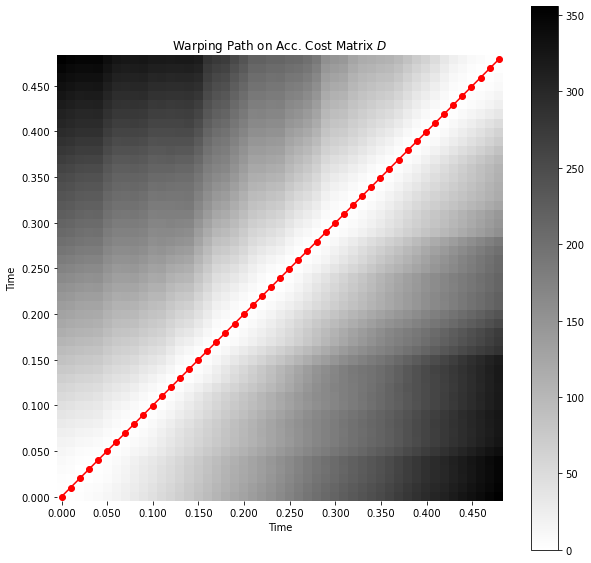

In [66]:
plotDTW(D, wp_s)

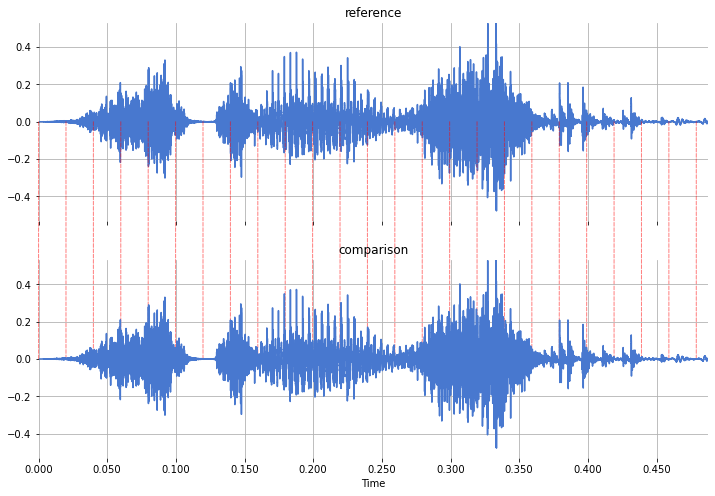

In [67]:
plotAlign(y_t2_trim, y_t5_trim)

In [68]:
x, y, re_wp = getDiff(t2_mfcc_norm, t5_mfcc_norm, wp)

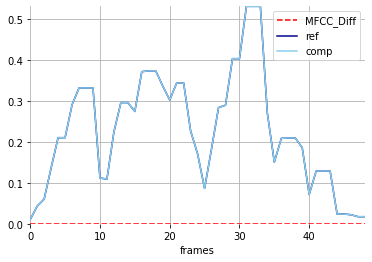

In [69]:
plotAll(x,y,t2_ae,t5_ae)

## Test 2: t2 vs t1 (t1 start nulled)

In [101]:
c = scipy.signal.correlate(y_t2_trim, y_t1_trim, mode="valid", method="fft")
peak = np.argmax(c)
offset = peak/sr
offset

0.09287981859410431

In [100]:
librosa.get_duration(y_t1_trim), librosa.get_duration(y_t2_trim)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/2737824288.py:1: FutureWarning: Pass y=[-1.6557710e-04  2.3165310e-04 -2.3187620e-04 ...  1.1156276e-03
 -3.5826117e-05  1.2470558e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t1_trim), librosa.get_duration(y_t2_trim)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/2737824288.py:1: FutureWarning: Pass y=[-3.1506643e-06 -6.3352287e-05 -1.0585971e-04 ...  1.1156276e-03
 -3.5826117e-05  1.2470558e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t1_trim), librosa.get_duration(y_t2_trim)


(0.3947392290249433, 0.4876190476190476)

In [102]:
zeros = np.zeros((int(offset*sr)),)
tmp = np.concatenate((zeros, y_t1_trim), axis=0)

In [103]:
librosa.get_duration(tmp)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/1092303027.py:1: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.11562759e-03
 -3.58261168e-05  1.24705583e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(tmp)


0.4876190476190476

In [106]:
tmp_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/2534493437.py:2: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.11562759e-03
 -3.58261168e-05  1.24705583e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


In [107]:
tmp_norm = getMFCCNorm(tmp_mfcc)

In [108]:
tmp_ae = amplitude_envelope(tmp, n_fft, hop_length)

In [109]:
D, wp, wp_s = DTW(t2_mfcc_norm, tmp_norm)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


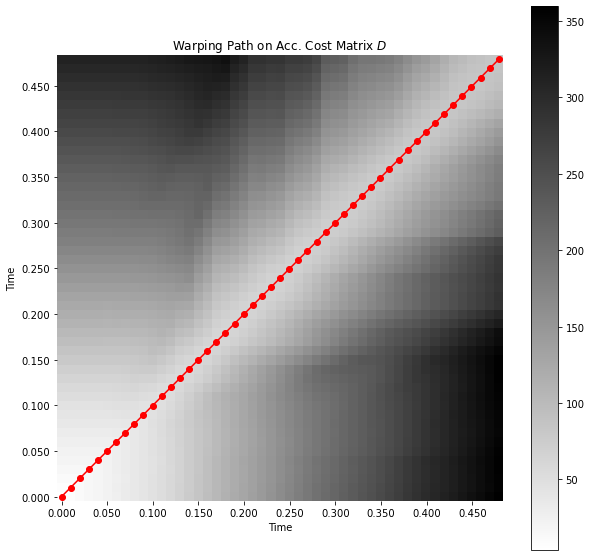

In [110]:
plotDTW(D, wp_s)

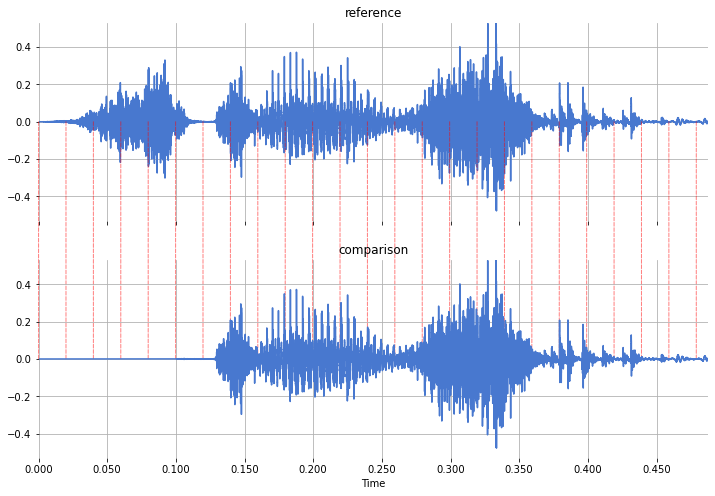

In [111]:
plotAlign(y_t2_trim, tmp)

In [112]:
x, y, re_wp = getDiff(t2_mfcc_norm, tmp_norm, wp)

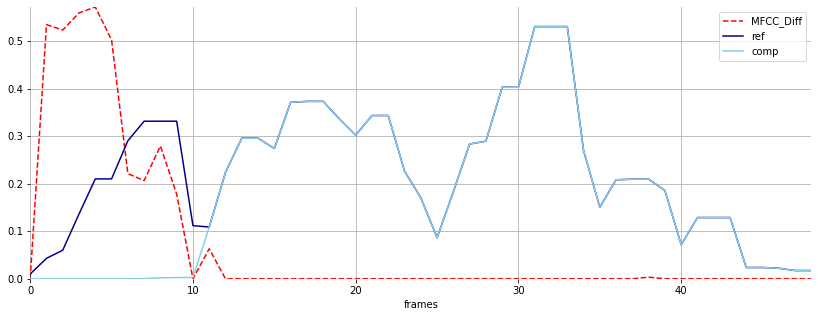

In [113]:
plotAll(x,y,t2_ae,tmp_ae)

In [121]:
ipd.Audio(y_t4_trim, rate=sr)

---

## Test 3: t4 vs t3 (t3 end nulled)

In [122]:
c = scipy.signal.correlate(y_t4_trim, y_t3_trim, mode="valid", method="fft")
peak = np.argmax(c)
offset = peak/sr
offset

0.0

In [134]:
diff = librosa.get_duration(y_t4_trim) - librosa.get_duration(y_t3_trim)
diff

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/3552021173.py:1: FutureWarning: Pass y=[ 1.7644032e-05 -1.6426509e-05  6.5842414e-07 ...  5.0610900e-03
 -1.6592219e-03  1.1178814e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(y_t4_trim) - librosa.get_duration(y_t3_trim)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/3552021173.py:1: FutureWarning: Pass y=[ 1.7644032e-05 -1.6426509e-05  6.5842414e-07 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(y_t4_trim) - librosa.get_duration(y_t3_trim)


0.1857596371882086

In [136]:
offset = round(diff * sr,0)
offset

4096.0

In [139]:
zeros = np.zeros((int(offset)),)
tmp = np.concatenate((y_t3_trim, zeros), axis=0)

In [140]:
librosa.get_duration(y_t4_trim), librosa.get_duration(tmp)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/428247098.py:1: FutureWarning: Pass y=[ 1.7644032e-05 -1.6426509e-05  6.5842414e-07 ...  5.0610900e-03
 -1.6592219e-03  1.1178814e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t4_trim), librosa.get_duration(tmp)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/428247098.py:1: FutureWarning: Pass y=[ 1.76440317e-05 -1.64265093e-05  6.58424142e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t4_trim), librosa.get_duration(tmp)


(0.5572789115646258, 0.5572789115646258)

In [141]:
tmp_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
tmp_norm = getMFCCNorm(tmp_mfcc)
tmp_ae = amplitude_envelope(tmp, n_fft, hop_length)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/2534493437.py:2: FutureWarning: Pass y=[ 1.76440317e-05 -1.64265093e-05  6.58424142e-07 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


In [142]:
D, wp, wp_s = DTW(t4_mfcc_norm, tmp_norm)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


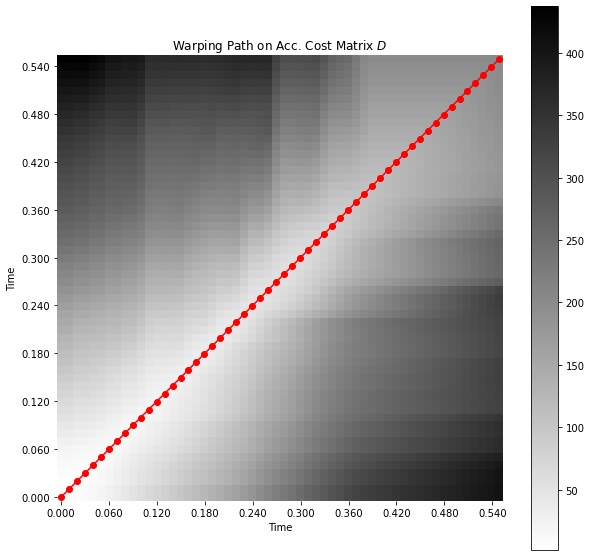

In [143]:
plotDTW(D, wp_s)

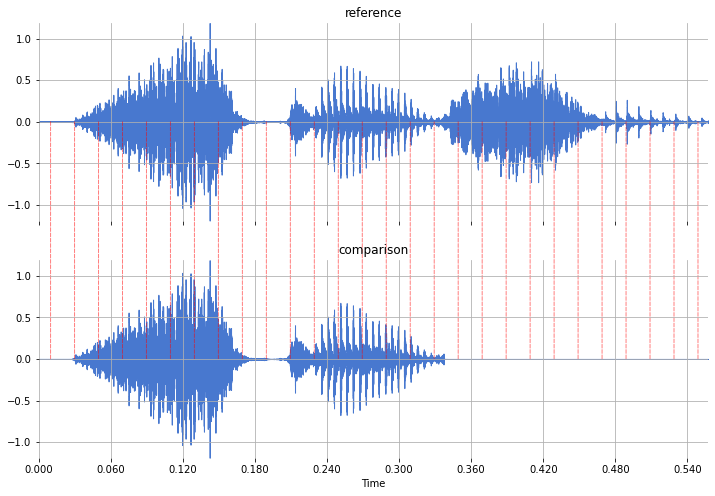

In [144]:
plotAlign(y_t4_trim, tmp)

In [145]:
x, y, re_wp = getDiff(t4_mfcc_norm, tmp_norm, wp)

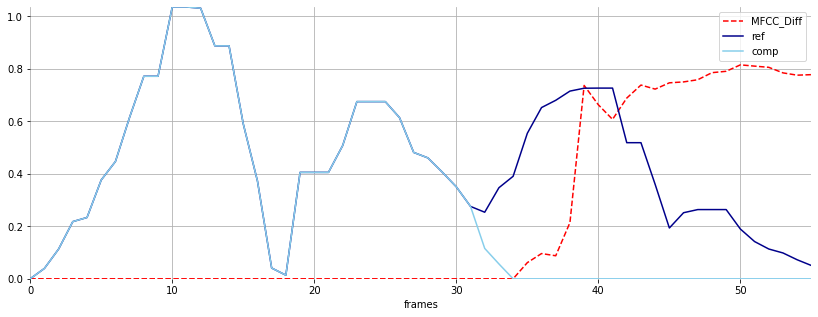

In [146]:
plotAll(x,y,t4_ae,tmp_ae)

---

## Test 4: t4 vs t5 (male vs female)

In [153]:
ipd.Audio(y_t4_trim, rate=sr)

In [154]:
librosa.get_duration(y_t4_trim), librosa.get_duration(y_t5_trim)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/1912922756.py:1: FutureWarning: Pass y=[ 1.7644032e-05 -1.6426509e-05  6.5842414e-07 ...  5.0610900e-03
 -1.6592219e-03  1.1178814e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t4_trim), librosa.get_duration(y_t5_trim)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/1912922756.py:1: FutureWarning: Pass y=[-3.1506643e-06 -6.3352287e-05 -1.0585971e-04 ...  1.1156276e-03
 -3.5826117e-05  1.2470558e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.get_duration(y_t4_trim), librosa.get_duration(y_t5_trim)


(0.5572789115646258, 0.4876190476190476)

In [155]:
c = scipy.signal.correlate(y_t4_trim, y_t5_trim, mode="valid", method="fft")
peak = np.argmax(c)
offset = peak/sr
offset

0.05020408163265306

In [156]:
zeros = np.zeros((int(offset*sr)),)
tmp = np.concatenate((zeros, y_t5_trim), axis=0)

In [159]:
diff = librosa.get_duration(y_t4_trim) - librosa.get_duration(tmp)
diff

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/3313636768.py:1: FutureWarning: Pass y=[ 1.7644032e-05 -1.6426509e-05  6.5842414e-07 ...  5.0610900e-03
 -1.6592219e-03  1.1178814e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(y_t4_trim) - librosa.get_duration(tmp)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/3313636768.py:1: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.11562759e-03
 -3.58261168e-05  1.24705583e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  diff = librosa.get_duration(y_t4_trim) - librosa.get_duration(tmp)


0.019455782312925107

In [160]:
zeros = np.zeros((int(diff*sr)),)
tmp = np.concatenate((tmp, zeros), axis=0)

In [162]:
round(librosa.get_duration(y_t4_trim) - librosa.get_duration(tmp),4)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/3486755058.py:1: FutureWarning: Pass y=[ 1.7644032e-05 -1.6426509e-05  6.5842414e-07 ...  5.0610900e-03
 -1.6592219e-03  1.1178814e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  round(librosa.get_duration(y_t4_trim) - librosa.get_duration(tmp),4)
/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/3486755058.py:1: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  round(librosa.get_duration(y_t4_trim) - librosa.get_duration(tmp),4)


0.0

In [163]:
tmp_mfcc = getMFCC(tmp, sr=sr, hop_length=hop_length, n_fft=n_fft, n_mfcc=13)
tmp_norm = getMFCCNorm(tmp_mfcc)
tmp_ae = amplitude_envelope(tmp, n_fft, hop_length)

/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/2534493437.py:2: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(signal, sr=sr, hop_length=hop_length, n_mfcc=n_mfcc, n_fft=n_fft)


/var/folders/_m/9sycz7bj0vlcb0sqw1yc6q400000gn/T/ipykernel_15501/4167920513.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


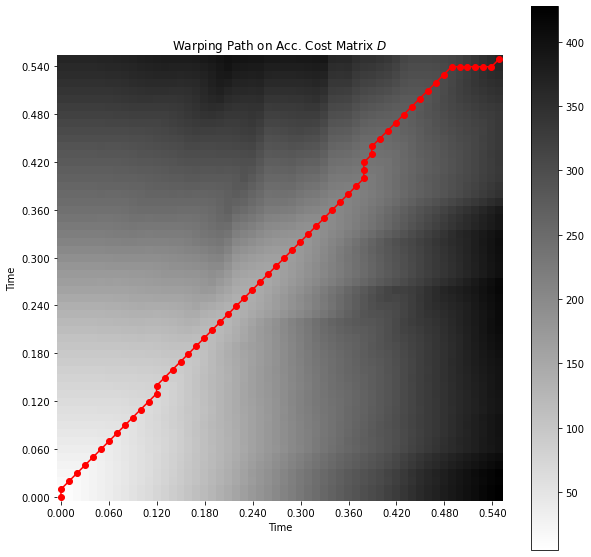

In [164]:
D, wp, wp_s = DTW(t4_mfcc_norm, tmp_norm)
plotDTW(D, wp_s)

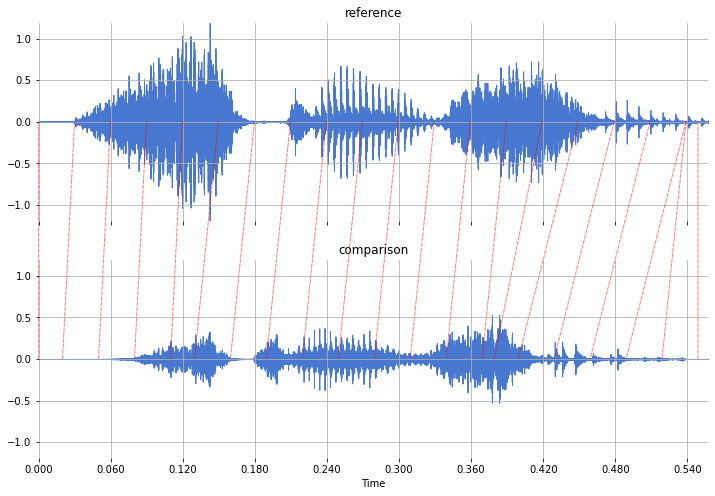

In [165]:
plotAlign(y_t4_trim, tmp)

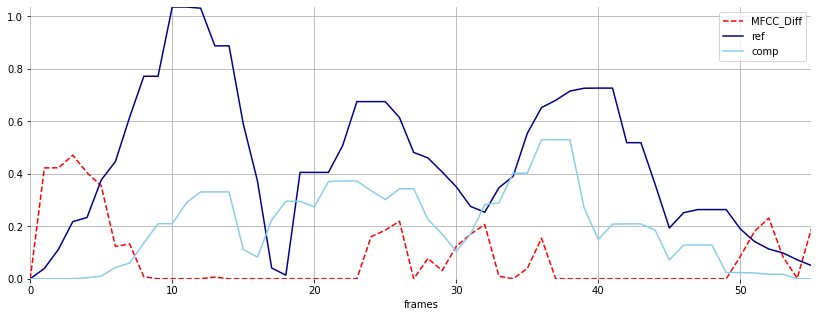

In [166]:
x, y, re_wp = getDiff(t4_mfcc_norm, tmp_norm, wp)
plotAll(x,y,t4_ae,tmp_ae)

---